In [81]:
import pandas as pd
import re
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, FunctionTransformer, StandardScaler
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.phrases import Phrases
from collections import Counter
import random

import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

These are the libraries required for our code, including data processing, machine learning, NLP, and visualization libraries.

In [3]:
#Import the Data
df = pd.read_csv('D:/Git/phase_4/Hades_reviews.csv')

#Check the Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457440 entries, 0 to 457439
Data columns (total 27 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      457440 non-null  int64  
 1   query_summary                   0 non-null       float64
 2   cursors                         0 non-null       float64
 3   recommendationid                228720 non-null  float64
 4   language                        228720 non-null  object 
 5   review                          228017 non-null  object 
 6   timestamp_created               228720 non-null  float64
 7   timestamp_updated               228720 non-null  float64
 8   voted_up                        228720 non-null  object 
 9   votes_up                        228720 non-null  float64
 10  votes_funny                     228720 non-null  float64
 11  weighted_vote_score             228720 non-null  float64
 12  comment_count   

## Data Cleaning

In [4]:
#Drop Nulls
df = df.dropna(subset=['review'])

#Keep only English reviews
df = df[df['language'] == 'english']

# Drop Unnecessary Columns
df = df.drop(df.columns[[0, 1, 2, 3, 4, 6, 7, 16, 17, 18]], axis=1)

# Create a mask where each review has more than 5 words and at least one alphabetic character
mask = df['review'].apply(lambda x: len(re.findall(r'\b\w+\b', str(x))) > 5 and bool(re.search('[a-zA-Z]', str(x))))

# Apply the mask to the DataFrame to filter out review
df = df[mask]

These lines drop the rows with missing values in the 'review' column, filter the DataFrame to keep only English reviews, and drop unnecessary columns from the DataFrame.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76744 entries, 228720 to 457437
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   review                          76744 non-null  object 
 1   voted_up                        76744 non-null  object 
 2   votes_up                        76744 non-null  float64
 3   votes_funny                     76744 non-null  float64
 4   weighted_vote_score             76744 non-null  float64
 5   comment_count                   76744 non-null  float64
 6   steam_purchase                  76744 non-null  object 
 7   received_for_free               76744 non-null  object 
 8   written_during_early_access     76744 non-null  object 
 9   author.num_games_owned          76744 non-null  float64
 10  author.num_reviews              76744 non-null  float64
 11  author.playtime_forever         76744 non-null  float64
 12  author.playtime_last_two_w

In [6]:
df.head()

,review,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played,timestamp_dev_responded,developer_response
228720,"Beautiful art and music, fun gameplay and grea...",True,0.0,0.0,0.0,0.0,True,False,False,0.0,1.0,18400.0,0.0,18400.0,1.624387e+09,NaN,NaN
228721,"Hades has a lot going for it the soundtrack, v...",True,0.0,0.0,0.0,0.0,True,False,False,189.0,44.0,1011.0,1011.0,1011.0,1.686744e+09,NaN,NaN
228723,"perfect loop, beautiful art, fun weapons",True,0.0,0.0,0.0,0.0,True,False,False,0.0,14.0,5790.0,5790.0,5790.0,1.686743e+09,NaN,NaN
228724,Combat : 10/10\nReplayabilty : 10/10\nStory + ...,True,0.0,0.0,0.0,0.0,True,False,False,0.0,4.0,5399.0,0.0,5399.0,1.670424e+09,NaN,NaN
228726,fun but u die alot LOL,True,0.0,0.0,0.0,0.0,False,False,False,0.0,2.0,330.0,330.0,270.0,1.686744e+09,NaN,NaN


### Step 1: Exploratory Data Analysis
These lines perform some EDA on the DataFrame, such as counting the number of positive and negative reviews, describing the playtime of the authors, calculating the length of each review, and providing summary statistics for the review length.

In [7]:
df['voted_up'].value_counts()

True     75508
False     1236
Name: voted_up, dtype: int64

With all the "positive" reviews listed here ('voted_up') our data set will be extremely imbalanced if we focus on targeting whether a review was positive or note. So let's consider some other features.

In [8]:
df['author.playtime_forever'].describe()

count     76744.000000
mean       5169.432190
std        6119.080535
min           5.000000
25%        1859.000000
50%        3914.000000
75%        6598.000000
max      272341.000000
Name: author.playtime_forever, dtype: float64

In [9]:
# Calculate the length of each review (in words)
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

# Calculate the average length of reviews
average_length = df['review_length'].mean()

df['review_length'].describe()

count    76744.000000
mean        48.357474
std         85.016701
min          1.000000
25%         11.000000
50%         22.000000
75%         50.000000
max       1600.000000
Name: review_length, dtype: float64

It looks like there is a nice spread in terms of play time and the length of reviews. Those might help us create a model with something to learn from.

#### Text preprocessing:

In [10]:
# Get list of stopwords
stop_words = set(stopwords.words('english'))

# Initialize a lemmatizer
lemmatizer = WordNetLemmatizer()

#Setup lemmatizer
def lemmatize_text(text):
    words = word_tokenize(text)
    filtered_words = [lemmatizer.lemmatize(w) for w in words if w.lower() not in stop_words]
    return ' '.join(filtered_words)

# Lemmatize the reviews
df['review'] = df['review'].apply(lemmatize_text)

These lines define a function lemmatize_text to lemmatize the review texts by removing stopwords and performing lemmatization. The function is then applied to the 'review' column using df['review'].apply(). Next, we want to check the variation of review length to see if we might have an unbalanced dataset.

In [11]:
# Encode review length into categories based on specific ranges or thresholds
df['review_length_category'] = pd.cut(df['review_length'], bins=[0, 8, 18, 44, np.inf], labels=[0, 1, 2, 3])

#Check value counts
df['review_length_category'].value_counts()

3    21715
1    21613
2    21249
0    12167
Name: review_length_category, dtype: int64

This looks like a an even spread! This could work as a variable.

In [57]:
# Calculate quantiles for playtime
df['playtime_category'] = pd.qcut(df['author.playtime_forever'], 3, labels=False)

# Check value counts
print(df['playtime_category'].value_counts())

0    25595
1    25577
2    25572
Name: playtime_category, dtype: int64


These lines encode the review length into categories based on specific ranges or thresholds and create a column indicating whether the playtime is low (1), average (2) or high (3). We will use this as our y variable.

### Preprocessing pipeline and model training

In [58]:
# Define preprocessing for text column
text_features = 'review'
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=2000))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, text_features)
    ])

# Sample 75% of data
df_sampled = df.sample(frac=0.75, random_state=42)

These lines define a preprocessing pipeline using ColumnTransformer to apply TF-IDF vectorization to the 'review' column and keep the 'above_average_playtime' column as numeric features. It then builds a pipeline with a RandomForestClassifier as the classifier. The data is split into training and testing sets using train_test_split, and the model is trained and evaluated using the classification report.

Now let's do a quick test of our data to see if we were right about the positive review prediction leading to overfitting due to an imbalanced data set. We will start with a simple *logistic regression model*:

In [30]:
# Redefine X and y for Logistic Regression model
X = df[['review']]  # Double brackets to create a DataFrame
y = df['voted_up'].map({True: 1, False: 0})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Set up the pipeline for the Logistic Regression model
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Fit the model and make predictions
logreg_pipeline.fit(X_train, y_train)
y_pred = logreg_pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.11      0.19       246
           1       0.99      1.00      0.99     15103

    accuracy                           0.99     15349
   macro avg       0.93      0.55      0.59     15349
weighted avg       0.98      0.99      0.98     15349



As predicted, our model is overfitting. So let's change tactics for our more complex models. Rather than trying to predict the positivity of a review based on its content, let's see if we can predict the length of a review by whether or not a player plays an above or below average amount. Because our data set is so large, we will only use a subset of the total data.

In [59]:
# Redefine X and y based on df_sampled
X = df_sampled[['review']]  # Double brackets to create a DataFrame
y = df_sampled['playtime_category']

# Then split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
df_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57558 entries, 337302 to 305453
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   review                          57558 non-null  object  
 1   voted_up                        57558 non-null  object  
 2   votes_up                        57558 non-null  float64 
 3   votes_funny                     57558 non-null  float64 
 4   weighted_vote_score             57558 non-null  float64 
 5   comment_count                   57558 non-null  float64 
 6   steam_purchase                  57558 non-null  object  
 7   received_for_free               57558 non-null  object  
 8   written_during_early_access     57558 non-null  object  
 9   author.num_games_owned          57558 non-null  float64 
 10  author.num_reviews              57558 non-null  float64 
 11  author.playtime_forever         57558 non-null  float64 
 12  author.playt

In [62]:
# Define pipeline for RandomForest
rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Fit the RandomForest model and make predictions
rf_clf.fit(X_train, y_train)
rf_y_pred_train = rf_clf.predict(X_train)
rf_y_pred_test = rf_clf.predict(X_test)

print("Classification Report for Random Forest Classifier (Training Data):")
print(classification_report(y_train, rf_y_pred_train))
print("\nClassification Report for Random Forest Classifier (Test Data):")
print(classification_report(y_test, rf_y_pred_test))

Classification Report for Random Forest Classifier (Training Data):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     15300
           1       0.98      0.98      0.98     15332
           2       0.99      0.98      0.99     15414

    accuracy                           0.98     46046
   macro avg       0.98      0.98      0.98     46046
weighted avg       0.98      0.98      0.98     46046


Classification Report for Random Forest Classifier (Test Data):
              precision    recall  f1-score   support

           0       0.42      0.46      0.44      3853
           1       0.35      0.28      0.31      3827
           2       0.40      0.45      0.43      3832

    accuracy                           0.40     11512
   macro avg       0.39      0.40      0.39     11512
weighted avg       0.39      0.40      0.39     11512



In [61]:
# Define pipeline for XGBoost
xgb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, 
                                 eval_metric='mlogloss', 
                                 objective='multi:softmax', 
                                 num_class=3)) 
])

# Fit the XGBoost model and make predictions
xgb_clf.fit(X_train, y_train)
xgb_y_pred_train = xgb_clf.predict(X_train)
xgb_y_pred_test = xgb_clf.predict(X_test)

# Classification report for XGBoost
print("\nClassification Report for XGBoost (Training Data):")
print(classification_report(y_train, xgb_y_pred_train))
print("\nClassification Report for XGBoost (Test Data):")
print(classification_report(y_test, xgb_y_pred_test))


Classification Report for XGBoost (Training Data):
              precision    recall  f1-score   support

           0       0.56      0.75      0.64     15300
           1       0.65      0.52      0.58     15332
           2       0.68      0.58      0.62     15414

    accuracy                           0.62     46046
   macro avg       0.63      0.62      0.61     46046
weighted avg       0.63      0.62      0.61     46046


Classification Report for XGBoost (Test Data):
              precision    recall  f1-score   support

           0       0.42      0.56      0.48      3853
           1       0.36      0.28      0.31      3827
           2       0.43      0.38      0.41      3832

    accuracy                           0.41     11512
   macro avg       0.40      0.41      0.40     11512
weighted avg       0.40      0.41      0.40     11512



It looks like the RFC model is having some overfitting issues, and our XGB is performing not muich better than a coinflip on the training and even worse on the teset. We'd like them to do better, so let's tune the hyperparameters of our XGB model (which performed slightly better) using GridSearchCV. Again, we will only use a small subset of the data to speed up processing time.

In [99]:
# Sample a subset of data for speed
X_train_sampled = X_train.sample(frac=0.25, random_state=42)
y_train_sampled = y_train.sample(frac=0.25, random_state=42)

# Set up the pipeline for the XGB model
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

param_grid = {
    'preprocessor__text__tfidf__max_features': [500, 1000, 2000],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [2, 5, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
}

# Initialize GridSearchCV with the XGBoost classifier and parameter grid
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, verbose=3, n_jobs=-1)

# Fit the GridSearchCV model
grid_search.fit(X_train_sampled, y_train_sampled)

# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best model found by GridSearchCV
best_model = grid_search.best_estimator_

# Predict the training set results using the best model
y_pred_train = best_model.predict(X_train)

# Generate classification report for the training data
report_train = classification_report(y_train, y_pred_train)

# Print the classification report
print("Classification Report (Training Data):\n", report_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 2, 'classifier__n_estimators': 200, 'preprocessor__text__tfidf__max_features': 2000}
Classification Report (Training Data):
               precision    recall  f1-score   support

           0       0.42      0.60      0.50     15300
           1       0.40      0.30      0.35     15332
           2       0.47      0.39      0.43     15414

    accuracy                           0.43     46046
   macro avg       0.43      0.43      0.42     46046
weighted avg       0.43      0.43      0.42     46046



Oh no! It looks like our only increased by a percentage or two, but we'll take it! However, it's still not better than a coin toss at this point. Let's visualzie the feature importances to see if there is anything to glean:

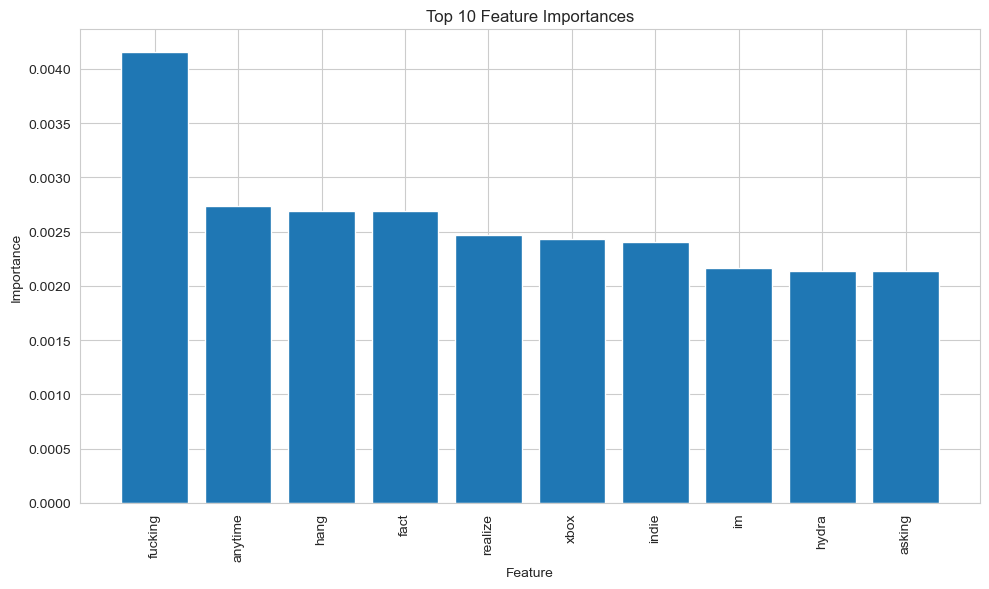

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Access the feature importances from the XGBoost classifier
feature_importances = xgb_clf.named_steps['classifier'].feature_importances_

# Get the TfidfVectorizer instance
tfidf_vectorizer = xgb_clf.named_steps['preprocessor'].transformers_[0][1]['tfidf']

# Get the feature names from the TfidfVectorizer's vocabulary
feature_names = np.array(list(tfidf_vectorizer.vocabulary_.keys()))

# Create a sorted list of feature importances and feature names
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_indices = sorted_indices[:10]  # Consider top 10 features
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importances)), sorted_feature_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

I guess people are using 'fucking' as a pretty high positive explainer. Not sure if many of the other words end up being all that helpful. Let's see if providing sentiment data might help.

## Sentiment Analysis

We are going to use TextBlob's NaiveBayesAnalyzer for our sentiment analysis. The NBA was trained on movie reviews, which is the closes we get to game reviews. To help it out, we are going to provide our model with 4 themes to look for in the data. We want to help our client figure out what it was exactly that people enjoyed about their games. Here are the themes:

In [73]:
# Define the themes and their associated words
themes = {
    'music': ['sound', 'music', 'audio', 'instrument', 'soundtrack', 'voice acting', 'song', 'effect', 'atmosphere', 'orchestra'],
    'story': ['story', 'plot', 'narrative', 'character', 'mission', 'quest', 'writing', 'dialogue', 'relationships', 'family', 'gods'],
    'game play': ['gameplay', 'rogue-like', 'mechanics', 'controls', 'action', 'fight', 'attack', 'battle', 'weapon', 'moves', 'power', 'combat', 'upgrade'],
    'visuals': ['visuals', 'graphics', 'art', 'images', 'color', 'artwork', 'animation', '2D', '3D', 'lighting']
}

Now we want to initiate our analyzer:

In [110]:
# Initiate TextBlob's sentiment analyzer
tb = NaiveBayesAnalyzer()

# Define a function to calculate the sentiment scores for each sentence
def get_sentiment(review):
    sentiments = []
    for sentence in review:
        blob = TextBlob(sentence, analyzer=tb)
        sentiment = blob.sentiment.p_pos
        sentiments.append(sentiment)
    return sentiments

# Define a function to calculate the general sentiment score of a review
def get_general_sentiment(review):
    blob = TextBlob(review)
    sentiment = blob.sentiment.polarity
    return sentiment

# Apply general sentiment analysis to each review in the selected data and create a general sentiment score column
df_sampled['general_sentiment'] = df_sampled['review'].apply(get_general_sentiment)

# Display the first five rows of the 'review' and 'general_sentiment' columns
print(df_sampled[['review', 'general_sentiment']].head(5))

                                                   review  general_sentiment
337302     game literal definition `` oh 's HOT ! '' love           0.137500
405174  brings many excellent element together , defin...           0.600000
281973  gon na say hades n't said ? 's good game folk ...           0.041667
303805  someone could barely go enjoy `` Dead Cells ''...           0.095000
309564  Refreshing find gem ! 's like warm embrace twi...           0.687500


We want to get sentiments on the general review level and on the sentence level. The more fine-grained the better! These functions, get_sentiment(review) and get_general_sentiment(review), takes a review as input and calculates the sentiment scores for each sentence in the review and review at large using TextBlob's sentiment analysis. It returns a list of sentiment scores.

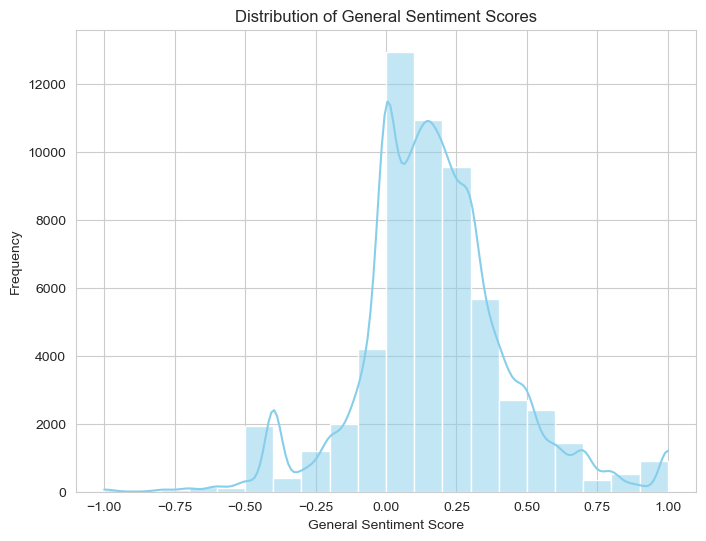

In [75]:
# Set up the figure and axes using seaborn
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

# Plot the general sentiment scores
sns.histplot(df_sampled['general_sentiment'], bins=20, kde=True, color='skyblue')

# Set labels and title
plt.xlabel('General Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of General Sentiment Scores')

# Show the plot
plt.show()

This histogram gives us more data than our logistic regression. We can see that rather than a simple binary of recommended or not, players had a range of sentiment concerning what they liked about the game. Now let's try and create a little program that can pick a review at random and display its content, its polarity, and which words within the review are contributing to that polarity based on the themes we provided:

In [94]:
# Select a random review index
review_index = random.randint(0, len(df_sampled) - 1)

# Retrieve the random review
review = df_sampled['review'].iloc[review_index]

theme_polarities = {}
for theme, words in themes.items():
    theme_polarities[theme] = []

    for word in words:
        keyword = f" {word} "  # Add spaces around the keyword to match whole words
        if keyword in review:
            keyword_sentiment = TextBlob(keyword, analyzer=tb).sentiment.p_pos
            theme_polarities[theme].append((word, keyword_sentiment))

# Print random review
print("Review Length:", len(review))
print()

print("Review:", review)
print()

# Print theme words and polarities
print("\033[3mTheme Words and Polarity\033[0m")
for theme, polarities in theme_polarities.items():
    if polarities:  # Check if polarities is not empty
        print(theme + ":", ", ".join([f"{word}, {polarity}" for word, polarity in polarities]))
    else:
        print(theme + ": not referenced")

Review Length: 67

Review: 10/10 fun gorgeous art , talented voice acting , addictive gameplay

Theme Words and Polarity
music: voice acting, 0.5484661905425029
story: not referenced
game play: not referenced
visuals: art, 0.5943396226415094


With this review we can see that it was generally positive, and liked the voice acting, story, gameplay, and art, with each recieving over .5 points in positive polarity. Now let's see if polarity can help our XGB model with its predictions:

In [109]:
# Include 'general_sentiment' in feature set
features = ['review', 'general_sentiment']
X = df_sampled[features]
y = df_sampled['playtime_category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for text column
text_features = 'review'
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=2000))
])

# Define preprocessing for sentiment column
sentiment_features = ['general_sentiment']
sentiment_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, text_features),
        ('sentiment', sentiment_transformer, sentiment_features)
    ])

# Define pipeline for XGBoost
xgb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', objective='multi:softmax', num_class=3))])
                   
                   
# Update the XGBClassifier with the best parameters
best_params = {'classifier__learning_rate': 0.1,
               'classifier__max_depth': 2,
               'classifier__n_estimators': 200,
               'preprocessor__text__tfidf__max_features': 2000}

xgb_clf.set_params(**best_params)

# Fit the XGBoost model and make predictions
xgb_clf.fit(X_train, y_train)
xgb_y_pred_train = xgb_clf.predict(X_train)
xgb_y_pred_test = xgb_clf.predict(X_test)

# Classification report for XGBoost
print("\nClassification Report for XGBoost (Training Data):")
print(classification_report(y_train, xgb_y_pred_train))
print("\nClassification Report for XGBoost (Test Data):")
print(classification_report(y_test, xgb_y_pred_test))


Classification Report for XGBoost (Training Data):
              precision    recall  f1-score   support

           0       0.42      0.65      0.51     15300
           1       0.44      0.26      0.33     15332
           2       0.48      0.42      0.45     15414

    accuracy                           0.44     46046
   macro avg       0.45      0.44      0.43     46046
weighted avg       0.45      0.44      0.43     46046


Classification Report for XGBoost (Test Data):
              precision    recall  f1-score   support

           0       0.41      0.62      0.49      3853
           1       0.37      0.22      0.28      3827
           2       0.44      0.38      0.41      3832

    accuracy                           0.41     11512
   macro avg       0.40      0.41      0.39     11512
weighted avg       0.40      0.41      0.39     11512



Unfortunately, it looks like adding sentiment score and using the best parameters from above made our model even worse!

#### Topic Modeling using LDA

Now for some additional verification, we are going to run an unsupervised learning model to see if it covers similar topics. Specifically we will use Gensim's Latent Dirichlet Allocation (LDA) model. We will prepare the reviews for LDA by removing the stopwords, lemmatizing them, and creating the dictionary and corpus needed for the topic modeling.

In [25]:
# Define a function to preprocess the texts
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove non-alphabetic tokens, such as punctuation
    words = [token.lower() for token in tokens if token.isalpha()]

    # Filter out stop words
    words = [word for word in words if word not in stop_words]

    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]

    return words

# Apply preprocessing to the review column
df['tokens'] = df['review'].apply(preprocess_text)

# Tokenize each review string into a list of tokens
tokenized_reviews = list(df['tokens'])

# Create a dictionary representation of the documents
dictionary = Dictionary(tokenized_reviews)

# Create Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(review) for review in tokenized_reviews]

# print out the first 5 documents in the corpus
for doc in corpus[:5]:
    print([[dictionary[id], freq] for id, freq in doc])

[['acting', 1], ['art', 1], ['beautiful', 1], ['fun', 1], ['game', 1], ['gameplay', 1], ['great', 1], ['like', 1], ['music', 1], ['really', 1], ['supergiant', 1], ['voice', 1]]
[['acting', 1], ['art', 1], ['fun', 1], ['game', 4], ['like', 2], ['really', 2], ['voice', 1], ['amazing', 1], ['animation', 1], ['annoying', 1], ['aspect', 1], ['aswell', 1], ['bastion', 1], ['beat', 1], ['becomes', 2], ['button', 2], ['combat', 1], ['death', 2], ['decide', 1], ['deep', 1], ['design', 1], ['disappointed', 1], ['escape', 1], ['everything', 1], ['extremely', 1], ['fan', 1], ['feel', 3], ['first', 1], ['get', 1], ['going', 1], ['grindy', 1], ['hades', 2], ['hour', 1], ['however', 1], ['issac', 1], ['least', 1], ['loose', 1], ['lot', 1], ['love', 1], ['made', 1], ['main', 1], ['mashy', 1], ['massive', 1], ['mid', 1], ['motivation', 1], ['overall', 1], ['polished', 1], ['press', 1], ['punishing', 2], ['quite', 1], ['recommend', 1], ['recommendation', 1], ['repetitive', 1], ['replaying', 1], ['rogue'

In [26]:
# Define the number of topics for the LDA model
num_topics = 10

# Train the LDA model
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary)

# Get the top 10 topics in the LDA model
top_topics = lda_model.show_topics(num_topics=10, num_words=10)

# Print the top 10 topics as single words
for topic_id, topic in top_topics:
    topic_words = [word.split('*')[1].replace('"', '').strip() for word in topic.split('+')]
    topic_words = ', '.join(topic_words)
    print(f"Topic {topic_id + 1}: {topic_words}")

Topic 1: game, hour, playing, really, get, fun, update, love, play, time
Topic 2: worth, price, money, bug, full, good, easy, hard, bad, sale
Topic 3: game, run, weapon, get, like, time, feel, even, make, different
Topic 4: good, stab, isaac, binding, b, die, pretty, gungeon, enter, u
Topic 5: hades, dead, pet, cell, god, cerberus, zagreus, underworld, dog, greek
Topic 6: great, game, gameplay, story, amazing, art, voice, fun, acting, music
Topic 7: game, best, one, played, access, early, supergiant, ever, like, even
Topic 8: game, character, story, gameplay, combat, well, fun, feel, great, hades
Topic 9: dash, hell, one, run, controller, con, pro, diablo, like, go
Topic 10: game, like, recommend, love, ca, wait, would, supergiant, dungeon, fun


It's hard to get a clear theme from these. Lots of action words, so perhaps 'gameplay' is a good theme? Or perhaps its too general. Let's check the top bigrams to see if they reveal anything else about the review topics:

In [27]:
# Initialize the bigram model
bigram_model = Phrases(tokenized_reviews, min_count=5, threshold=100)

# Get the top bigrams
top_bigrams = list(bigram_model.export_phrases())

# Print the top 10 bigrams
print("Top 10 bigrams:")
for bigram in top_bigrams[:10]:
    print(bigram)

Top 10 bigrams:
button_mashy
hack_slash
learning_curve
keyboard_mouse
greek_mythology
gon_na
early_access
floating_head
fishing_minigame
top_notch


Some of these look helpful. We might categorize button_mashy, hack_slash, learning_curve, keyboard_mouse, and fishing_minigame as 'gameplay' topics, and greek_mythology as 'story.' Let's see if we get any more clarity by limiting our bigrams to our pre-selected themes:

In [28]:
# Create a dictionary to store the theme bigrams
theme_bigrams = {}

# Filter the top bigrams based on themes and their synonyms
for theme, words in themes.items():
    theme_bigrams.setdefault(theme, [])
    
    for bigram in top_bigrams:
        if any(word in bigram for word in words):
            theme_bigrams[theme].append(''.join(bigram))

# Print the top 5 bigrams for each theme
for theme, bigrams in theme_bigrams.items():
    print(f"Top 5 bigrams for {theme.capitalize()} theme:")
    for bigram in bigrams[:5]:
        count = len(bigram.replace('_', ''))
        print(f"{bigram}: Count - {count}")
    print()

Top 5 bigrams for Music theme:
sound_track: Count - 10
instead_audio: Count - 12
audio_eargasm: Count - 12
musical_score: Count - 12
mass_effect: Count - 10

Top 5 bigrams for Story theme:
side_quest: Count - 9
question_asked: Count - 13
family_drama: Count - 11
extended_family: Count - 14
answer_question: Count - 14

Top 5 bigrams for Game play theme:
attack_pattern: Count - 13
power_ups: Count - 8
el_combate: Count - 9
power_creep: Count - 10
micro_transaction: Count - 16

Top 5 bigrams for Visuals theme:
late_party: Count - 9
add_cart: Count - 7
vibrant_color: Count - 12
color_palette: Count - 12
farewell_earthly: Count - 15



That is definitely more useful! We we are able to see which of the words are associated with each them, and how often those pairs appeared. Now let's step back and see how often our themes appeared more generally. 

In [29]:
# Create a dictionary to store theme appearance counts
theme_appearance_counts = {theme: 0 for theme in themes}

# Iterate over each review
for review in df['review']:
    # Check if each theme is mentioned in the review at least once
    for theme, words in themes.items():
        if any(word in review for word in words):
            theme_appearance_counts[theme] += 1

# Print the theme appearance counts
for theme, count in theme_appearance_counts.items():
    print(f"{theme}: {count} appearances")

music: 15901 appearances
story: 28991 appearances
game play: 27548 appearances
visuals: 17288 appearances


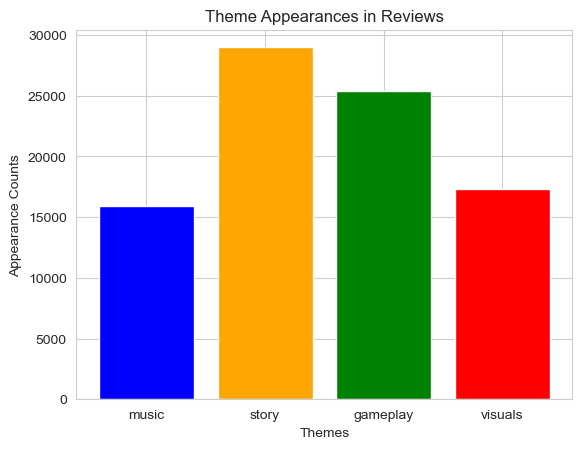

In [30]:
# Define the themes and their appearance counts
themes = ['music', 'story', 'gameplay', 'visuals']
appearance_counts = [15901, 28991, 25387, 17288]

# Define colors for the bars
colors = ['blue', 'orange', 'green', 'red']

# Create a bar chart with colored bars
plt.bar(themes, appearance_counts, color=colors)

# Customize the chart
plt.xlabel('Themes')
plt.ylabel('Appearance Counts')
plt.title('Theme Appearances in Reviews')

# Display the chart
plt.show()

# Conclusion

1) The reviews for the game Hades generally expressed positive sentiment, although the overall level of positivity falls within the range of 0 to 0.25.

2) When discussing their experiences with the game, players frequently emphasized the importance of the game's story. This indicates that the narrative elements of Hades are a significant aspect of player enjoyment.

3) It appears that players may have limited vocabulary when describing their appreciation for the 'music' and 'visuals' in Hades. This suggests that while players find these aspects appealing, they may struggle to articulate their specific likes or preferences regarding the music and visual elements of the game.

# Reccomendations

Based on these findings, I would recommend SuperGiant Games to continue focusing on the strong storytelling elements of Hades, as players consistently highlighted this aspect. Additionally, efforts can be made to enhance players' ability to express their positive impressions of the 'music' and 'visuals' by potentially providing prompts or specific questions related to these aspects in reviews or feedback forms. This would help gather more detailed and insightful feedback on the game's audio and visual components.

## Limitations

Given the computational limitations, making confident predictions about the specific aspects of the game that received positive reviews remains challenging. However, we were successful in adding complexity to the analysis of reviews by incorporating sentiment analysis and exploring themes within the text. This approach has revealed potential insights and indicates the value of delving deeper into the analysis. Further investigation into the sentiment scores of specific themes and their impact on overall sentiment could provide valuable insights into the aspects of the game that resonate with reviewers. Despite the challenges, our findings suggest that there is merit in continuing to explore and refine our analysis methods to gain a deeper understanding of the factors contributing to positive reviews.

### For Further Research

I'd like to check the sentiment scores for each of our themes. So I need code that looks at the sentiment scores of the sentences of each review, determines whether or not the sentence is referring to a particular one of our 4 themes, and then adds that score to the proper theme column. For each review. 

In [31]:
# Create theme sentiment columns in the DataFrame
for theme in themes:
    df[theme + '_sentiment'] = 0.0

# Iterate over each review
for review in df['review']:
    # Initialize sentiment scores for each theme
    theme_scores = {theme: 0.0 for theme in themes}
    
    # Calculate sentiment score for each sentence in the review
    for sentence in review:
        for theme, words in themes.items():
            if any(word in sentence for word in words):
                sentiment = TextBlob(sentence, analyzer=tb).sentiment.p_pos
                theme_scores[theme] += sentiment
    
    # Add the sentiment scores to the DataFrame
    for theme, score in theme_scores.items():
        df.loc[df['review'] == review, theme + '_sentiment'] = score

AttributeError: 'list' object has no attribute 'items'

In [ ]:
# Apply sentiment analysis to each sentence in the selected data
df_sampled['sentiment'] = df_sampled['review'].apply(get_sentiment)
# Create theme-specific sentiment score columns
for theme in themes:
    theme_column = f'{theme}_sentiment'
    df_sampled[theme_column] = df_sampled['sentiment'].apply(lambda sentiments: [sentiment for sentiment in sentiments if isinstance(sentiments, list) and isinstance(sentiment, str) and theme in sentiment])

In [ ]:
# Set the size of the scatter points
point_size = 50

# Create a scatter plot for each theme
fig, axes = plt.subplots(nrows=len(themes), figsize=(8, 12))

for i, (theme, ax) in enumerate(zip(themes, axes)):
    sentiment_column = f'{theme}_sentiment'
    
    # Get the sentiment scores and review lengths for the theme
    sentiment_scores = df[sentiment_column].explode().values
    review_lengths = df['review'].apply(len).values
    
    # Create the color map for sentiment scores
    cmap = plt.cm.coolwarm
    norm = plt.Normalize(vmin=min(sentiment_scores), vmax=max(sentiment_scores))
    colors = cmap(norm(sentiment_scores))
    
    # Create the scatter plot
    ax.scatter(review_lengths, sentiment_scores, c=colors, cmap='coolwarm', s=point_size, alpha=0.7, edgecolors='black', label=theme)
    
    ax.set_xlabel('Review Length')
    ax.set_ylabel('Sentiment Score')
    ax.set_title(f'Sentiment Scores vs Review Length for {theme.capitalize()} Theme')
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Set up colors for each theme
theme_colors = ['red', 'blue', 'green', 'orange']

# Set the width of each bar
bar_width = 0.15

# Set the x coordinates for the bars
x = np.arange(len(themes))

# Plot the sentiment scores for each theme side by side
plt.figure(figsize=(8, 6))

for i, theme in enumerate(themes.keys()):
    sentiment_column = f'{theme}_sentiment'
    theme_sentiments = df[sentiment_column].explode().dropna()
    
    # Calculate the x position for each theme's bar
    x_pos = x[i]
    
    # Plot histogram of sentiment scores with the corresponding color and x position
    plt.hist(theme_sentiments, bins=5, range=(0, 1), alpha=0.7, edgecolor='black',
             color=theme_colors[i], label=theme, align='mid', rwidth=bar_width)

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution for Themes')
plt.xticks(x, themes.keys())
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Create a dictionary to store theme appearance counts
theme_appearance_counts = {theme: 0 for theme in themes}

# Define the threshold for selecting bigrams
threshold = 5

# Iterate over each review
for review in df['review']:
    # Check if each theme is mentioned in the review at least once
    for theme, words in themes.items():
        if any(word in review for word in words):
            theme_appearance_counts[theme] += 1

            # Create a list of theme-related sentences
            theme_sentences = [sentence for sentence in review.split('.') if any(word in sentence for word in words)]

            # Tokenize the theme-related sentences
            tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in theme_sentences]

            # Create a finder to identify bigrams
            finder = BigramCollocationFinder.from_documents(tokenized_sentences)

            # Apply a frequency filter to select relevant bigrams
            finder.apply_freq_filter(threshold)

            # Get the top 5 most common bigrams with sentiment words
            top_bigrams = finder.nbest(BigramAssocMeasures.raw_freq, 5)

            # Print the top bigrams
            print(f'Top bigrams for {theme.capitalize()} theme:')
            for bigram in top_bigrams:
                print(' '.join(bigram))
            print()

# Print the theme appearance counts
for theme, count in theme_appearance_counts.items():
    print(f"{theme}: {count} appearances")

Maybe check to see how my pre-selected themes did in terms of meaningful score using the LDA:

In [ ]:
# Create a dictionary to store theme sentiment scores
theme_sentiments = {theme: [] for theme in themes}

# Iterate over each review
for review in df['review']:
    # Calculate sentiment score for each sentence in the review
    for sentence in review:
        for theme in themes:
            if any(word in sentence for word in themes[theme]):
                sentiment = TextBlob(sentence, analyzer=tb).sentiment.p_pos
                theme_sentiments[theme].append(sentiment)

# Print theme sentiment scores
for theme, sentiments in theme_sentiments.items():
    print(f"{theme.capitalize()} Sentiment Scores: {sentiments}")